In [64]:
%matplotlib inline
import numpy as np
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# from https://www.youtube.com/watch?v=kCc8FmEb1nY&t=3925s

In [37]:
text = open("./input.txt", 'r', encoding='utf-8').read()
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [12]:
len(text)

1115394

In [20]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [23]:
# tokenizer: we encode/decode strings into integer arrays (keep it simple). GPT uses tiktoker
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

encode = lambda string : [stoi[ch] for ch in string]
decode = lambda array : ''.join([itos[i] for i in array])


In [34]:
encode("hello world")
decode(encode("hello world"))

'hello world'

In [40]:
# the data
data = torch.tensor(encode(text), dtype=torch.int64)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [44]:
# create the training/validation splits
n = int(0.9 * len(data))
data_train = data[:n]
data_val = data[n:]
print(data_train.shape, data_train.dtype)
print(data_val.shape, data_val.dtype)


torch.Size([1003854]) torch.int64
torch.Size([111540]) torch.int64


In [59]:
b = torch.randint(0, data_train.shape[0] - 8, (4,)) 
a = torch.stack([data_train[i:i+8] for i in b],dim=0)
a

tensor([[57, 54, 43, 39, 49,  1, 52, 53],
        [50, 53, 61,  1, 63, 53, 59,  8],
        [14, 33, 30, 37, 10,  0, 35, 47],
        [ 6,  1, 42, 47, 57, 41, 46, 39]])

In [60]:
# create the batch. 
batch_size = 4 # how many sequencies (randomly generated) will fill the transformer at once
block_size = 8 # the maximum lenght of the context
# the input will be then a 4x8 tensor

def get_batch(split : str):
    dat = data_train if split == "train" else data_val
    ix = torch.randint(0, dat.shape[0] - block_size, (batch_size,)) # create 4 random indeces
    X =  torch.stack([dat[i:i+block_size] for i in ix])
    Y =  torch.stack([dat[i+1:i+block_size+1] for i in ix])
    return X, Y

In [61]:
xb, yb = get_batch('train')

In [62]:
xb,yb

(tensor([[39, 56, 51, 57,  8,  0,  0, 22],
         [61,  1, 47, 58,  6,  1, 61, 53],
         [ 1, 58, 53, 50, 42,  1, 53, 52],
         [40, 50, 43,  1, 39, 52, 42,  1]]),
 tensor([[56, 51, 57,  8,  0,  0, 22, 27],
         [ 1, 47, 58,  6,  1, 61, 53, 59],
         [58, 53, 50, 42,  1, 53, 52,  5],
         [50, 43,  1, 39, 52, 42,  1, 45]]))

In [142]:
# let us start with a bigram model (for comparison with the transformer)
torch.manual_seed(1234)

class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        self.vocab_size = vocab_size
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # (Batch 4, Time 8, Channels vocab_size)

        if targets == None: 
            loss = None
        else: 
            # reshape
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)

            loss = F.cross_entropy(logits, targets) # this expects to be B, C (the channels to the second input)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx) # (B, T, C), idx: (B, T)
            # print(logits.shape)
            logits = logits[:, -1, :] # becomes (B , C) we get the latest prediction -1
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)
             
        return idx




m = BigramModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape, loss)

torch.Size([256, 65]) tensor(4.8541, grad_fn=<NllLossBackward0>)



s$VR&mP'xOXt3fTxwKb$!?$Kn?,aUs'ao3Jm:QcJwp
K!Uh:mEkwOssPcDIUwH&hk,kCoiuL3jEUjhNMw$TaHmMz.iRCz.VVn:i?


In [143]:
# optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [144]:
stepi, lossi = [], []

In [150]:
batch_size = 32
epochs = 1000

for epoch in (t :=trange(epochs)):

    # get batch
    xb, yb = get_batch('train')
    #forward
    logits, loss = m(xb, yb)
    #backward
    optimizer.zero_grad(set_to_none=True) # first we set to zero the gradients
    loss.backward() # compute the gradients
    optimizer.step() # update the parameters
    
    stepi.append(epoch)
    lossi.append(loss.item())
    t.set_description(f"loss: {loss}") 


loss: 2.4569528102874756: 100%|███| 1000/1000 [00:04<00:00, 248.21it/s]


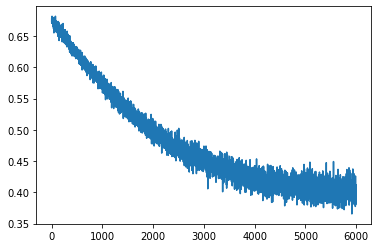

In [155]:
plot(np.log10(lossi))

In [156]:
def write_text(max_tokens):
    print(decode( m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=max_tokens)[0].tolist() ))

In [159]:
write_text(200)


ANGSBZAUpuGfFRk be otew$Rithifonoroue winghoube y Ofed whir s his intr i
FI y wan;
HMEind mjIO!
YUK:

Ca?-ch If t be hy truse so oll tth
TENTINR:

Sprvevof tirs Sthed s sQDome ig it theng; ETEN pt?$d



# Self-attention

In [204]:
# example
torch.manual_seed(1234)
B, T, C = 4, 8, 2 # batch, time, context
x = torch.randn(B,T,C)
x.shape


torch.Size([4, 8, 2])

In [205]:
# we want to correlate each of the tokens, but in a certain way. We want to communicate only with the future.
# Version 1: a way to correlate is just to take the average, but averaged in this specfic way. Its not the best way to correlate but it's a start.

# we want x[b,t] = mean_{i <= t} x[b,i]

xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1, :]
        # print(xprev.shape)
        xbow[b,t] = torch.mean(xprev, dim=0, keepdim=True)

print(xbow.shape)

torch.Size([4, 8, 2])


In [221]:
wei = torch.tril(torch.ones((T,T)))
wei = wei / torch.sum(wei, dim=1, keepdim=True)
xbow2 = wei @ x # (T x T) x (B x T x C) ->(B x T x T) x (B x T x C) = B x T x C
xbow2.shape

torch.Size([4, 8, 2])

In [227]:
#version 3. Using softmax
tril = torch.tril(torch.ones((T,T)))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [228]:
#version 4. Self-attention. Here the weights are not zero, so the interaction is not the same between the previous tokens, but it is data dependent. The way it works (kinda) is that every token produces to vectors, the so called keys and queries. The dot product with this two will be the weight.
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B,T,C)

# a head of self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)
q = query(x)
v = value(x)
# no communication so far
wei = q @ v 

tril = torch.tril(torch.ones((T,T)))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])